# Direct Comparison of Quantum 3SAT algorithm and classical counterpart.  

## Shared functions/dependencies 

In [1]:
# Needed for functions
import time
import numpy as np
from numpy import pi
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import random

#import packages for classical algorithm
import ctypes
from numpy import ctypeslib as npct

#import packages for quantum algorithm
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import qiskit.quantum_info as qi

Build 3SAT instance with only one solution

In [2]:
# def buildSatSingleSolution(numVar):
#     sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3]]
#     for n in range(4,numVar+1):
#         sat.append([-2,-3,-n])
#         sat.append([2,3,-n])
#         sat.append([-2,-3,n])
#     return sat

def buildSatSingleSolution(numVar):
    sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3]]
    for n in range(4,numVar+1):
        sat.append([2,3,n])
        sat.append([-2,-3,-n])
        sat.append([-2,-3,n])
        
    return sat

## Stochastic algorithm

Get c++ function to run stochastic algorithm

In [3]:
#initialize variables for classical solver
array_1d_double = npct.ndpointer(dtype=np.double, ndim=1, flags='CONTIGUOUS')
array_1d_int = npct.ndpointer(dtype=np.int_, ndim=1, flags='CONTIGUOUS')

c_lib_numpy = npct.load_library("lib/SATProbCalc.so", ".")

c_lib_numpy.SolveSATbpp.restype = ctypes.c_int #ctypes.POINTER(ctypes.c_double * (10**2))
c_lib_numpy.SolveSATbpp.argtypes = [ctypes.c_int, array_1d_double, ctypes.c_int, ctypes.c_int]

def SolveSATbpp(n, sat, clauses, iterations):
    steps = c_lib_numpy.SolveSATbpp(n, sat.flatten(), clauses, iterations)
    return steps

Functions for getting probability of finding solution with stochastic algorithm

In [4]:
def classicalStatistics(n, SAT, c, i, numRuns):
    stepList = []
    for x in range(numRuns):
        stepList.append(SolveSATbpp(n, SAT, c, i))
#     counter = Counter(stepList)
#     res = {item: count for item, count in counter.items()}
#     print(res)
    return stepList

def classicalSolve2(n,SAT,c,i,numIt):

    SAT = np.array(SAT).astype('double')
#     for x in range(len(SAT)):
#         SAT[x] = -SAT[x]

    start = time.time()
    res = classicalStatistics(n, SAT, c, i, numIt)
    print("C++ time to solve: " , start - time.time())

    return res

def classicalSolve(n,SAT,c,i,numIt):

    SAT = np.array(SAT).astype('double')
#     for x in range(len(SAT)):
#         SAT[x] = -SAT[x]
    # print(SAT)

    start = time.time()
    res = classicalStatistics(n, SAT, c, i, numIt)
    print("C++ time to solve: " , start - time.time())

    return res

## Quantum algorithm

Helper functions / gates

In [5]:
def OR(a,b,c,d,e,circuit):
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.ccx(a,b,d)
    circuit.ccx(c,d,e)
    circuit.x(a)
    circuit.x(b)
    circuit.x(c)
    circuit.x(e)
    circuit.reset(d)

def AND(a,b,c,d,e,circuit):
    circuit.ccx(a,b,d)
    circuit.ccx(c,d,e)
    circuit.reset(d)
    
def had3(e,a,b,c,circuit,par):
    circuit.ch(e,abs(a)-1)
    circuit.ch(e,abs(b)-1)
    circuit.ch(e,abs(c)-1)
    
def hadAll(e,a,b,c,circuit,par):
    for b in range(par['nQ']):
        circuit.ch(e,b)
#     circuit.ch(e,abs(a)-1)
#     circuit.ch(e,abs(b)-1)
#     circuit.ch(e,abs(c)-1)
    
        
def remStates(a,b,c,d,circuit):
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
    
    circuit.rcccx(abs(a)-1,abs(b)-1,abs(c)-1,d)
        
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
         
def endRem(a,b,c,d,e,circuit):
    if a < 0:
        circuit.x(abs(a)-1)
    if b < 0:
        circuit.x(abs(b)-1)
    if c < 0:
        circuit.x(abs(c)-1)
        
def qft3(c,q1,q2,q3):
    c.h(abs(q3)-1)
    c.cp(pi/4, abs(q1)-1, abs(q3)-1)
    c.cp(pi/2, abs(q2)-1, abs(q3)-1)
    c.h(abs(q2)-1)
    c.cp(pi/2, abs(q1)-1, abs(q2)-1)
    c.h(abs(q1)-1)
    c.swap(abs(q1)-1,abs(q3)-1)
    
def qft3i(c,q1,q2,q3):
    c.swap(abs(q1)-1,abs(q3)-1)
    c.h(abs(q1)-1)
    c.cp(-pi/2, abs(q1)-1, abs(q2)-1)
    c.h(abs(q2)-1)
    c.cp(-pi/2, abs(q2)-1, abs(q3)-1)
    c.cp(-pi/4, abs(q1)-1, abs(q3)-1)
    c.h(abs(q3)-1)

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n, s):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[s:n+s])
    return circuit.decompose() # .decompose() allows us to see the individual gates
    

Build quantum circuit

In [6]:
# SAT problem that will be implemented in circuit
# sat = [[-1,-2,-3],[-1,2,3],[1,-2,3],[1,2,-3],[-1,-2,3],[-1,2,-3],[1,-2,-3],[-2,-3,4],[-2,-3,-4],[-2,-3,5],[-2,-3,-5],[-2,-3,6],[-2,-3,-6],[-2,-3,7],[-2,-3,-7],[2,3,4],[2,3,5],[2,3,6],[2,3,7]]

def buildCircuit(par,measure):
    helper = 1 #number of ancillary qubits
    h = par['nQ'] #qubit that can be used for calculations

    qr = QuantumRegister(par['nQ']+helper, 'q')
    cr = ClassicalRegister(par['nQ'], 'c')
    c = QuantumCircuit(qr, cr)

    # Hadimard all qubits used in SAT
    if par['had']:
        for x in range(par['nQ']):
            c.h(x)
                
    for n in range(par['numIt']): # Repeat circuit numIt times
#         random.shuffle(par['sat'])
        for clause in par['sat']: # loop through all clauses in the SAT instance
            
            
            remStates(clause[0],clause[1],clause[2],h,c)
            had3(h,clause[0],clause[1],clause[2],c,par)
            c.reset(h)
            
            c.barrier(qr)  
            
    if measure:
        c.measure(qr[:-1],cr)
            
    return c

In [7]:
def setup(nQ):
    par = {}
    par['nQ'] = nQ

    #Plotting Conditionals
    par['latex'] = True
    par['statevector'] = True
    par['measure'] = False
    par['saveEnd'] = False
    par['figName'] = "Plots/TestSave2/{:0>6}.png"
    par['sat'] = buildSatSingleSolution(par['nQ'])#[[1,2,3],[4,5,6]]
    par['numIt'] = len(par['sat'])
    par['had'] = True;
    print(par['numIt'])
    state = ''
    for q in range(nQ):
        state = state + '0'
    par['state'] = state
    
    return par

## Exhaustive search for solution

Helper functions for classical exhaustive search of solutions to SAT instance

In [8]:
def checkSAT(SAT, state, c, n):
        
    for t in range(c):
        # //get the variables the clause is interested in
        seive = (1 << (abs(int(SAT[t][0])) - 1)) + (1 << (int(abs(SAT[t][1])) - 1)) + (1 << (int(abs(SAT[t][2])) - 1))
        # //get the values in the clause to xor
        gate = 0
            
        if (SAT[t][0] > 0):
            gate += 1 << (abs(int((SAT[t][0]))) - 1)
        if (SAT[t][1] > 0):
            gate += 1 << (abs(int((SAT[t][1]))) - 1)
        if (SAT[t][2] > 0):
            gate += 1 << (abs(int((SAT[t][2]))) - 1)

        a = seive & state
        b = gate ^ a

        if (b == 0):
            return False
    return True

def exhausting(SAT,c,n):
#     print(1 << 1 == 2)
    solutions = []
    
    for t in range(c):
        print((int(SAT[t][0]))," ",(int(SAT[t][1]))," ",(int(SAT[t][2])))
    
    for s in range(0,2**n):
        state = int(s)
        if(checkSAT(SAT, state, c, n)):
            solutions.append(state)
    return solutions
            

In [9]:
# SAT = buildSatSingleSolution(n)
# # random.shuffle(SAT)
# solutions = exhausting(SAT,c,n)
# print(solutions)

# myKeys = list(res.keys())
# myKeys.sort()
# sorted_dict = {i: res[i] for i in myKeys}
 
# print(sorted_dict)
# plt.plot(list(map(int,sorted_dict.keys())),sorted_dict.values())

In [10]:
n = 6
SAT = buildSatSingleSolution(n)
c = 3*n -2
i = 1000
numIt = 10000000

res = classicalSolve2(n,SAT,c,i,numIt)

values, base = np.histogram(res, bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
# plt.plot(base[:-1], cumulative/numIt, c='blue')

C++ time to solve:  -92.50352764129639


In [11]:
solutions = exhausting(SAT,c,n)
print(solutions)

-1   -2   -3
-1   2   3
1   -2   3
1   2   -3
-1   -2   3
-1   2   -3
1   -2   -3
2   3   4
-2   -3   -4
-2   -3   4
2   3   5
-2   -3   -5
-2   -3   5
2   3   6
-2   -3   -6
-2   -3   6
[7]


In [12]:
from qiskit import Aer, transpile
# import qiskit.providers.aer
from qiskit_aer import AerError

print(Aer.backends())

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_density_matrix = Aer.get_backend('aer_simulator_density_matrix')
    simulator_density_matrix.set_options(device='GPU')
except AerError as e:
    print(e)



[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_statevector_gpu'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_density_matrix_gpu'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_unitary_gpu'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator'), PulseSimulator('pulse_simulator')]


In [16]:
par = setup(n)
# maxIt = n**2
maxIt = n**2
probList = []

xs = np.linspace(1,maxIt,num = maxIt,dtype='int')
for it in xs:
    par['numIt']  = it
    shots = 10000

    # Build circuit
    start = time.time()
    c = buildCircuit(par,True)
    circ = transpile(c, simulator_density_matrix, optimization_level=0)
    job_density_matrix = simulator_density_matrix.run(circ, shots=shots)
    counts_density_matrix = job_density_matrix.result().get_counts(0)

#     print(counts_density_matrix)

#     if(par['statevector']):
#         # Execute and get counts
#         DM = qi.DensityMatrix.from_instruction(c)
#         # probs = DM.probabilities_dict()
#         DM2 = qi.partial_trace(DM,[par['nQ']])
#         probs = DM2.probabilities_dict()

    print("Iteration " + str(it) + " took " + str(start-time.time()))
    
    total = 0
    
    for state in counts_density_matrix:
        if(checkSAT(par['sat'], int(state, 2), len(par['sat']), par['nQ'])):
            total += counts_density_matrix[state]
            
            
#     names = list(probs.keys())
#     values = list(probs.values())
    
#     totalProb = 0
#     for s in solutions:
# #         if f'{s:nb}'
#         totalProb += list(probs.values())[s]
    probList.append(total/shots)
    
# plt.plot(xs, probList, c='red')

16
0.08773446083068848  : time taken for density_matrix
{'001000': 5, '100000': 10, '101001': 4, '011110': 29, '101111': 21, '100110': 56, '001001': 4, '110111': 13, '110000': 3, '100111': 80, '011111': 19, '000001': 17, '110001': 4, '011100': 204, '010101': 292, '100001': 9, '100101': 391, '101110': 21, '000110': 376, '111010': 203, '110101': 333, '001011': 244, '111100': 201, '110011': 272, '000111': 572, '000011': 352, '010001': 3, '000100': 339, '010110': 82, '110010': 233, '001111': 98, '010010': 236, '011001': 2, '111101': 252, '111111': 4, '100010': 274, '100100': 286, '000000': 19, '101011': 231, '011011': 197, '110110': 9, '010000': 1, '111011': 194, '001100': 247, '101100': 234, '000010': 255, '001010': 214, '101000': 5, '001110': 103, '101101': 237, '001101': 225, '100011': 341, '010111': 97, '111110': 4, '101010': 215, '011010': 187, '110100': 250, '011101': 264, '011000': 1, '010100': 251, '000101': 384, '010011': 291}
Iteration 1 took -0.14379024505615234
0.09473347663879

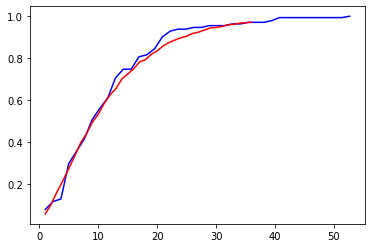

In [17]:
plt.plot(base[:-1]+1, cumulative/numIt, c='blue')
plt.plot(xs, probList, c='red')